<a href="https://colab.research.google.com/github/Frans-Grau/ElectricVehicleVsChargingStations/blob/main/EVPopulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pyspark

In [2]:
import pandas as pd
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession


In [3]:
spark = SparkSession.builder.appName("EVPop").getOrCreate()
url = "https://raw.githubusercontent.com/Frans-Grau/ElectricVehicleVsChargingStations/main/Datasets/EVPopulation.csv"
from pyspark import SparkFiles
spark.sparkContext.addFile(url)

dfEV = spark.read.csv("file://"+SparkFiles.get("EVPopulation.csv"), header=True, inferSchema= True)

In [4]:
dfEV.show(1)

+----------+------+-------+-----+-----------+----------+-------------+---------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+----------------+-----------------+
|VIN (1-10)|County|   City|State|Postal Code|Model Year|         Make|    Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|    Vehicle Location|Electric Utility|2020 Census Tract|
+----------+------+-------+-----+-----------+----------+-------------+---------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+----------------+-----------------+
|WDC0G5EB7K|Louisa|Bumpass|   VA|      23024|      2019|MERCEDES-BENZ|GLC-CLASS| Plug-in Hybrid El...|                             Not eligible due ...|            10|        0|             

In [5]:
dfEV.printSchema()

root
 |-- VIN (1-10): string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Model Year: integer (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric Vehicle Type: string (nullable = true)
 |-- Clean Alternative Fuel Vehicle (CAFV) Eligibility: string (nullable = true)
 |-- Electric Range: integer (nullable = true)
 |-- Base MSRP: integer (nullable = true)
 |-- Legislative District: integer (nullable = true)
 |-- DOL Vehicle ID: integer (nullable = true)
 |-- Vehicle Location: string (nullable = true)
 |-- Electric Utility: string (nullable = true)
 |-- 2020 Census Tract: long (nullable = true)



## EDA on the filtered DF -> State = Washington

In [6]:
### Filter dfEV to just values in WA and save into a new dataframe
df1 = dfEV.filter(dfEV.State == 'WA')


In [7]:
### Check for Null values -> the whole df
from pyspark.sql.functions import isnan, when, count, col, isnull
df1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df1.columns]).show()

+----------+------+----+-----+-----------+----------+----+-----+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|VIN (1-10)|County|City|State|Postal Code|Model Year|Make|Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|Vehicle Location|Electric Utility|2020 Census Tract|
+----------+------+----+-----+-----------+----------+----+-----+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|         0|     0|   0|    0|          0|         0|   0|   84|                    0|                                                0|             0|        0|                   0|             0|              27|             159|                0|


In [8]:
### Check for null values -> 1 column at a time 
from pyspark.sql.functions import col 
df1.filter(col('Model').isNull()).count()

84

In [9]:
### Compare SIZE after removing all nulls
dfWA = df1.na.drop()
print('df1 - Original: ', (df1).count(), len(df1.columns))
print('dfWA - Without Null values: ', (dfWA).count(), len(dfWA.columns))

df1 - Original:  114312 17
dfWA - Without Null values:  114042 17


In [10]:
### County information
dfWA.groupBy('County').count().orderBy('count', ascending=False).show()

+------------+-----+
|      County|count|
+------------+-----+
|        King|60005|
|   Snohomish|12686|
|      Pierce| 8670|
|       Clark| 6824|
|    Thurston| 4179|
|      Kitsap| 3880|
|     Whatcom| 2873|
|     Spokane| 2828|
|      Benton| 1394|
|      Island| 1297|
|      Skagit| 1240|
|     Clallam|  737|
|    San Juan|  724|
|   Jefferson|  699|
|      Chelan|  653|
|      Yakima|  633|
|     Cowlitz|  575|
|       Mason|  554|
|       Lewis|  437|
|Grays Harbor|  397|
+------------+-----+
only showing top 20 rows



In [11]:
### City Information
dfWA.groupBy('City').count().orderBy('count', ascending=False).show(2)

### Count of distinct cities 
dfWA.select('City').distinct().count()

+--------+-----+
|    City|count|
+--------+-----+
| Seattle|20591|
|Bellevue| 5986|
+--------+-----+
only showing top 2 rows



441

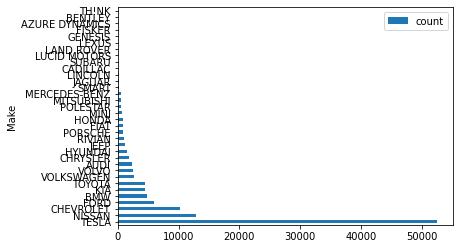

In [12]:
### CAR MAKERS: Value Counts and use pnadas to plot
makers = dfWA.groupBy('Make').count().orderBy('count', ascending=False)
p_makers = makers.toPandas()
p_makers = p_makers.set_index('Make')
p_makers.plot(kind='barh')

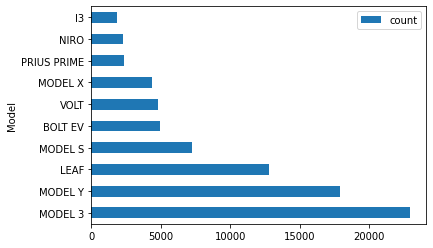

In [13]:
### CAR MODELS: Value Counts and use paadas to plot
models = dfWA.groupBy('Model').count().orderBy('count', ascending=False)
p_models = models.toPandas()
p_models.set_index('Model', inplace=True)
p_models[:10].plot(kind='barh')

In [14]:
### Electric Vehicle Type: Value Counts 
ev_type = dfWA.groupBy('Electric Vehicle Type').count().orderBy('count', ascending=False)
ev_type.show()

+---------------------+-----+
|Electric Vehicle Type|count|
+---------------------+-----+
| Battery Electric ...|87379|
| Plug-in Hybrid El...|26663|
+---------------------+-----+



In [15]:
### TODO:
# Predict 'Electric Range' to change the 0 range values
range = dfWA.groupBy('Electric Range').count().orderBy('count', ascending=False)
range.show(2)


+--------------+-----+
|Electric Range|count|
+--------------+-----+
|             0|41429|
|           215| 6213|
+--------------+-----+
only showing top 2 rows



### Predicting Missing Electric Range

In [16]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import isnan, when, count, col

In [18]:
df_original = dfWA
# Define the input columns for the string indexer
input_cols = ['County', 'City', 'State', 'Make', 'Model',
              'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
              'Legislative District', 'Vehicle Location', 'Electric Utility']

# Define the output columns for the string indexer
output_cols = [col + "_indexed" for col in input_cols]

# Create the string indexer
string_indexer = StringIndexer(inputCols=input_cols, outputCols=output_cols)

# Fit the string indexer to the data
string_indexer_model = string_indexer.fit(df_original)

# Transform the data to create the indexed columns
df_indexed = string_indexer_model.transform(df_original)


# Define the input columns for the one-hot encoder
input_cols = output_cols

# Define the output columns for the one-hot encoder
output_cols_enc = [col + "_encoded" for col in input_cols]

# Create the one-hot encoder
encoder = OneHotEncoder(inputCols=input_cols, outputCols=output_cols_enc)

# Transform the data to create the one-hot encoded columns
encoder.setDropLast(False)
ohe = encoder.fit(df_indexed) 
df_indexed = ohe.transform(df_indexed)
df_encoded = df_indexed


### vector assembler
input_cols = output_cols_enc
vector_assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
df_original=vector_assembler.transform(df_encoded)


In [19]:
# Split the dataset into training and test sets
training_data, test_data = df_original.randomSplit([0.7, 0.3], seed=123)

# Train the model
lr = LinearRegression(featuresCol='features', labelCol='Electric Range', maxIter=10, regParam=0.3, elasticNetParam=0.8)
model = lr.fit(training_data)

# Make predictions on the test set
predictions = model.transform(test_data)

In [20]:
predictions.select('Electric Range', 'prediction').show(10, False)

+--------------+------------------+
|Electric Range|prediction        |
+--------------+------------------+
|25            |29.566000103098553|
|25            |29.566000103098553|
|25            |29.566000103098553|
|25            |29.566000103098553|
|25            |29.566000103098553|
|25            |29.566000103098553|
|21            |19.834007621773416|
|21            |19.834007621773416|
|21            |19.834007621773416|
|21            |19.834007621773416|
+--------------+------------------+
only showing top 10 rows



In [21]:
# Evaluate the model
evaluator = RegressionEvaluator(labelCol="Electric Range", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

In [22]:
rmse

4.100195931768802

In [24]:
# Make predictions on the test set
predictions1 = model.transform(df_original)



In [25]:
predictions1.select('Electric Range', 'prediction').show(10, False)

+--------------+------------------+
|Electric Range|prediction        |
+--------------+------------------+
|291           |287.31510790199917|
|322           |319.7260079361203 |
|215           |213.85901205156904|
|19            |18.902792529801914|
|19            |21.49640674258343 |
|151           |148.0679790965724 |
|204           |199.75048255729482|
|150           |147.21145424755412|
|322           |319.7260079361203 |
|150           |147.21145424755412|
+--------------+------------------+
only showing top 10 rows



In [26]:
df_final = predictions1.select('County','City','State','Make','Model'\
                               ,'Postal Code','Model Year','Electric Vehicle Type'\
                               ,'Base MSRP','DOL Vehicle ID','2020 Census Tract'\
                               ,'Clean Alternative Fuel Vehicle (CAFV) Eligibility'\
                               ,'Legislative District','Vehicle Location','Electric Utility'\
                               ,'Electric Range','prediction')

In [35]:
df_final.filter(col("Prediction").contains('-')).count()

21058

In [39]:
df_final = df_final.withColumn('Range', when(col('Electric Range')!=0,col('Electric Range')).otherwise(df_final.prediction))

In [45]:
df_final.filter(col("Electric Range")==0).select('Range','prediction').show()

+--------------------+--------------------+
|               Range|          prediction|
+--------------------+--------------------+
|  -4.234770394771289|  -4.234770394771289|
|  -7.587591537832651|  -7.587591537832651|
| -1.2212409249979288| -1.2212409249979288|
|   2.073484033489791|   2.073484033489791|
| -12.830138978210556| -12.830138978210556|
|   2.073484033489791|   2.073484033489791|
|   2.073484033489791|   2.073484033489791|
|   2.073484033489791|   2.073484033489791|
|  1.6283759011575256|  1.6283759011575256|
| -1.2212409249979288| -1.2212409249979288|
|   2.073484033489791|   2.073484033489791|
| -1.2212409249979288| -1.2212409249979288|
|   2.073484033489791|   2.073484033489791|
|  -2.763955690476166|  -2.763955690476166|
|   2.073484033489791|   2.073484033489791|
|   5.893475500505744|   5.893475500505744|
|-0.10674753222318145|-0.10674753222318145|
|   2.073484033489791|   2.073484033489791|
|  0.4156992739304002|  0.4156992739304002|
|   2.073484033489791|   2.07348